# Detecting Systemic Bias in Hospitality Reviews

### Abstract
To find indications of unfair treatment, bias, or systemic behaviour that can impact access, experience, or reputation, this report looks at Yelp reviews of restaurants, hotels, spas, and nightlife in **Edmonton, Nashville, and New Orleans**. By having both (a) **bias-related terms** (such as "discriminated," "treated differently," and "profiling") and (b) **negative sentiment** in the same review, I'm also able to distinguish between simple negativity and **potential bias**. Furthermore, I visualize **city maps** to highlight **localized clusters** and analyze **geographic differences** using **postal codes** as neighbourhood proxies.

Yelp business data was filtered to include only hospitality venues then balanced samples across cities. I then did EDA to profile rating distributions, review volumes, and business-type mix by city. Reviews were cleaned with NLP preprocessing, sentiment-scored using VADER, and flagged for bias-related keywords. Bias was defined as the occurrence of both flagged terms with negative sentiment. At the neighborhood level, I aggregated results by postal code and also applied dynamic KMeans clustering on geographic coordinates to reveal finer-grained hotspots.

In [33]:
import pandas as pd
import json
import numpy as np
import re
import os

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP + ML
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Mapping
import folium
from folium.plugins import HeatMap

# Misc
import swifter

business_path = 'business.json'
review_path   = 'review.json'

# Plot style
plt.style.use('default')
sns.set_context('notebook')
sns.set_palette('husl')


In [6]:
# Helper func to load large JSON
def load_json(path, nrows=None):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        if nrows:
            for i, line in enumerate(f):
                if i >= nrows:
                    break
                data.append(json.loads(line))
        else:
            for line in f:
                data.append(json.loads(line))
    return pd.DataFrame(data)

# Load business data and filter for target cities
business = load_json(business_path)
target_cities = {'Nashville', 'New Orleans', 'Edmonton'}
target_business_ids = set(business[business['city'].isin(target_cities)]['business_id'])

# Load reviews and filter based on the target business IDs
filtered_reviews = []
with open(review_path, 'r', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] in target_business_ids:
            filtered_reviews.append(review)

review_df = pd.DataFrame(filtered_reviews)

print("Business dim:", business.shape)
print("Review dim:", review_df.shape)

display(business.head())
display(review_df.head())

Business dim: (150346, 14)
Review dim: (1188758, 9)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
1,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
2,z0osLHDvXvzfm57D4DmD2Q,xVKE_HJ2pwUtTdLbL3pnCg,S2Ho8yLxhKAa26pBAm6rxA,3.0,0,0,0,"Service was crappy, and food was mediocre. I ...",2016-11-22 00:22:53
3,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
4,p198qZsKOMCUhgdtRWsOKQ,3MpDvy5gEdsbZh9-p92dHg,8QnuWGVNBhzyYXGSeRdi4g,4.0,0,0,0,After my ROTD yesterday of a different Sweet ...,2013-10-24 19:24:33


### Hospitality Filter

We keep hospitality categories (lodging, food & beverage, spas/wellness, nightlife) and explicitly exclude Car Rental (from personal inspection of what was accidentally being included)

In [7]:
hospitality_include = [
    "Hotel", "Hostel", "Motel", "Resort", "Inn",
    "Restaurant", "Café", "Cafe", "Diner", "Eatery",
    "Spa", "Wellness", "Massage", "Hot Spring",
    "Bar", "Brewery", "Pub", "Nightlife", "Coffee", "Bakery", "Wine Bar", "Lounge"
]

hospitality_exclude = [
    "Car Rental"
]

def is_hospitality(categories: str) -> bool:
    if not isinstance(categories, str):
        return False
    cats = categories.lower()
    inc = any(k.lower() in cats for k in hospitality_include)
    exc = any(k.lower() in cats for k in hospitality_exclude)
    return inc and not exc

hospitality_business = business[business['categories'].apply(is_hospitality)].copy()

print("Hospitality businesses found:", len(hospitality_business))
display(hospitality_business.head(10))

Hospitality businesses found: 80171


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."


### Select and Sample Businesses

I narrow the dataset to hospitality businesses from Edmonton, New Orleans, and Nashville, then take a balanced sample (up to 5,000/city) so that all their reviews are included.

In [8]:
cities = ['Edmonton', 'New Orleans', 'Nashville']
hosp = hospitality_business[hospitality_business['city'].isin(cities)].copy()

print("Hospitality businesses by city:")
print(hosp['city'].value_counts(), "\n")

np.random.seed(42)

def sample_up_to(df, n=5000):
    if len(df) <= n:
        return df
    return df.sample(n=n, random_state=42)

sampled_biz = hosp.groupby('city', group_keys=False).apply(sample_up_to)
print("Sampled hospitality businesses by city:")
print(sampled_biz['city'].value_counts(), "\n")
print("Total sampled businesses:", len(sampled_biz))

biz_ids = set(sampled_biz['business_id'])


Hospitality businesses by city:
city
Nashville      3960
New Orleans    3900
Edmonton       3089
Name: count, dtype: int64 

Sampled hospitality businesses by city:
city
Nashville      3960
New Orleans    3900
Edmonton       3089
Name: count, dtype: int64 

Total sampled businesses: 10949


### Load Reviews for Selected Businesses

I stream the reviews JSON and keep only the ones whose `business_id` is in our selected business set

In [9]:
filtered_reviews = []
with open(review_path, 'r', encoding='utf-8') as f:
    for line in f:
        r = json.loads(line)
        if r['business_id'] in biz_ids:
            filtered_reviews.append(r)

reviews = pd.DataFrame(filtered_reviews)
print("Reviews shape:", reviews.shape)
display(reviews.head())

# Attach business city + postal_code + coords
reviews = reviews.merge(
    sampled_biz[['business_id','city','postal_code','latitude','longitude','categories']],
    on='business_id', how='left', suffixes=('','_biz')
)
reviews.rename(columns={'city':'city'}, inplace=True)

print("\nReviews merged w/ business metadata:")
display(reviews[['review_id','business_id','city','postal_code','stars','date']].head())


Reviews shape: (1044848, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
1,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
2,z0osLHDvXvzfm57D4DmD2Q,xVKE_HJ2pwUtTdLbL3pnCg,S2Ho8yLxhKAa26pBAm6rxA,3.0,0,0,0,"Service was crappy, and food was mediocre. I ...",2016-11-22 00:22:53
3,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
4,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5.0,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21



Reviews merged w/ business metadata:


,review_id,business_id,city,postal_code,stars,date
0,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,New Orleans,70119,4.0,2017-01-14 20:54:15
1,6AxgBCNX_PNTOxmbRSwcKQ,gmjsEdUsKpj9Xxu6pdjH0g,New Orleans,70170,5.0,2015-01-03 23:21:18
2,z0osLHDvXvzfm57D4DmD2Q,S2Ho8yLxhKAa26pBAm6rxA,New Orleans,70130,3.0,2016-11-22 00:22:53
3,elqRpX9T3YwL07uLNtN3Bg,ltBBYdNzkeKdCNPDAsxwAA,Nashville,37203,2.0,2015-02-02 04:29:13
4,E9AB7V4z8xrt2uPF7T55FQ,Zx7n8mdt8OzLRXVzolXNhQ,Nashville,37203,5.0,2018-04-27 23:03:21


## EDA


### City-Level Ratings & Review Distributions

My hypothesis is that Yelp ratings should be typically skewed positive due to self-selection and positivity bias. I visualize overall distributions and city-level summaries here (this is *not* the bias analysis yet).

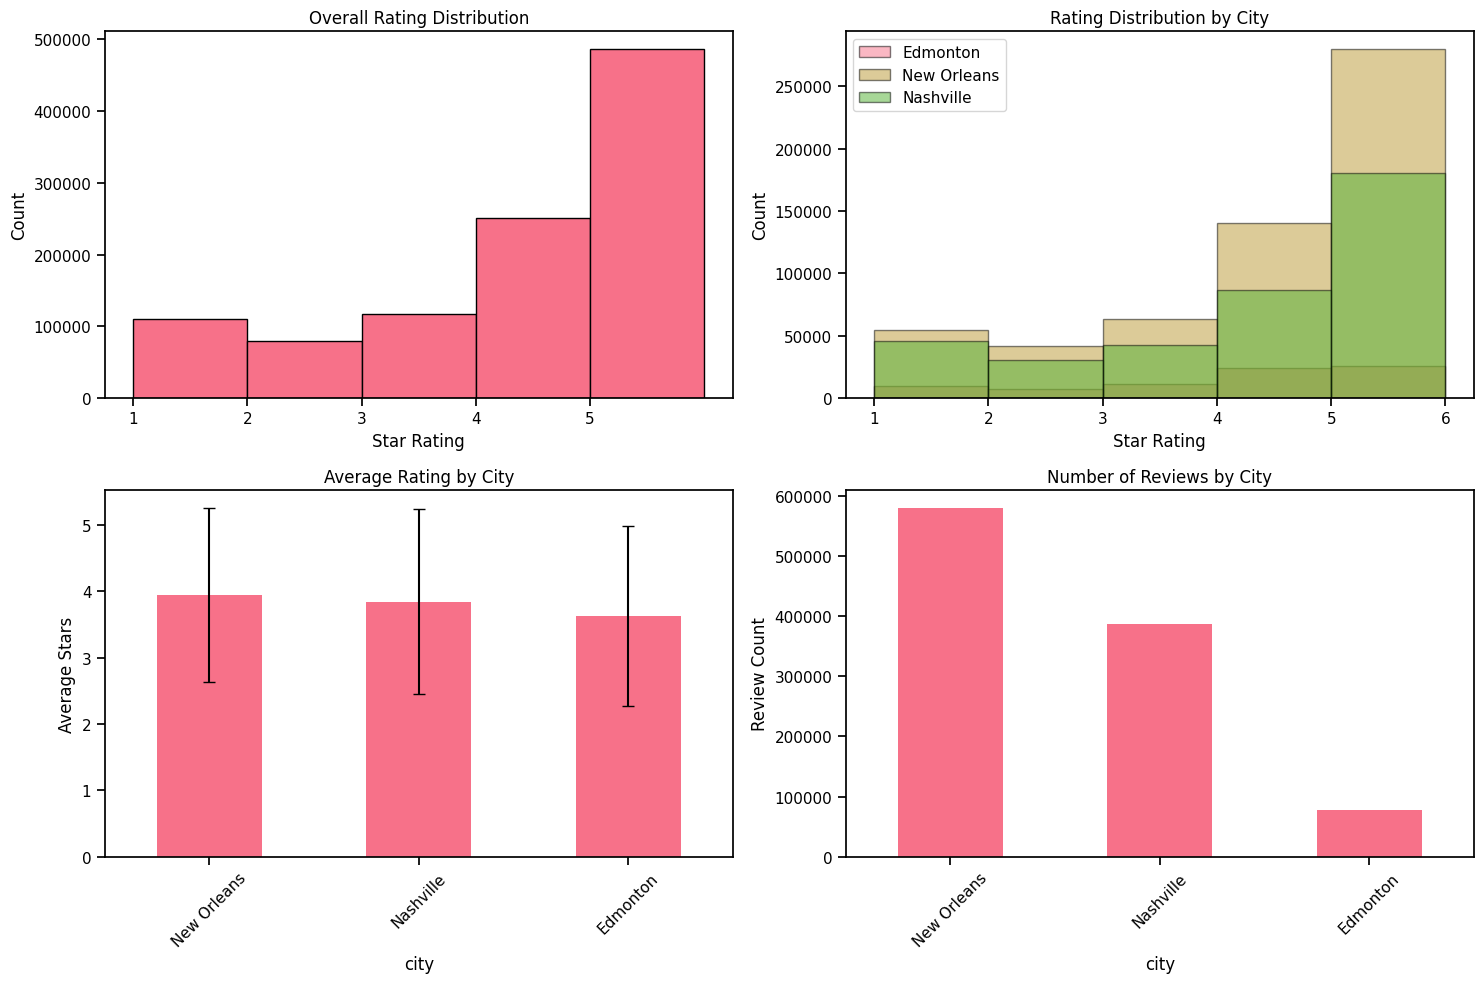

Average rating by city:


,mean,std,count
city,,,
New Orleans,3.95,1.31,580497
Nashville,3.84,1.39,386223
Edmonton,3.62,1.35,78128


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall rating distribution
axes[0,0].hist(reviews['stars'], bins=[1,2,3,4,5,6], edgecolor='black')
axes[0,0].set_title('Overall Rating Distribution')
axes[0,0].set_xlabel('Star Rating')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticks([1,2,3,4,5])

# Rating distribution by city
for city in cities:
    city_data = reviews.loc[reviews['city']==city, 'stars']
    axes[0,1].hist(city_data, bins=[1,2,3,4,5,6], alpha=0.5, edgecolor='black', label=city)
axes[0,1].set_title('Rating Distribution by City')
axes[0,1].set_xlabel('Star Rating')
axes[0,1].set_ylabel('Count')
axes[0,1].legend()

# Average rating by city
city_stats = reviews.groupby('city')['stars'].agg(['mean','std','count']).sort_values('mean', ascending=False)
city_stats.plot(kind='bar', y='mean', yerr='std', ax=axes[1,0], capsize=4, legend=False)
axes[1,0].set_title('Average Rating by City')
axes[1,0].set_ylabel('Average Stars')
axes[1,0].tick_params(axis='x', rotation=45)

# Review volume by city
reviews['city'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Number of Reviews by City')
axes[1,1].set_ylabel('Review Count')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Average rating by city:")
display(city_stats.round(2))

#### Conclusions from City-Level Ratings & Reviews

1. **Overall Rating Distribution**
   - As I expected, the dataset shows a strong positive skew.
   - There are spikes at 1-star and 5-star which indicates people tend to leave extreme ratings rather than moderate ones; an extreme responding bias so to speak.

2. **City-Level Rating Patterns**
   - New Orleans has the highest average rating (3.95), followed by Nashville** (3.84), and Edmonton** (3.62).
   - Edmonton’s lower average suggests lower perceived service quality or possibly harsher customer expectations since it's in Canada.
   - Standard deviations around ~1.3–1.4 across cities mean there's high variability in customer experiences. Could also be subjective interpreations of Yelp's rating scale (i.e, what consitutes a 6 vs 5 star review?).

3. **Review Volume**
   - New Orleans dominates here with ~580k reviews, showing it’s a major hub for customers. Nashville (~386k) and Edmonton (~78k) have significantly fewer reviews.

### Business Type Classification (EDA Con't)

Here, I roughly classify and plot hospitality businesses by type to check whether bias-context concentrations differ by theme/cuisine/type for supporting context.

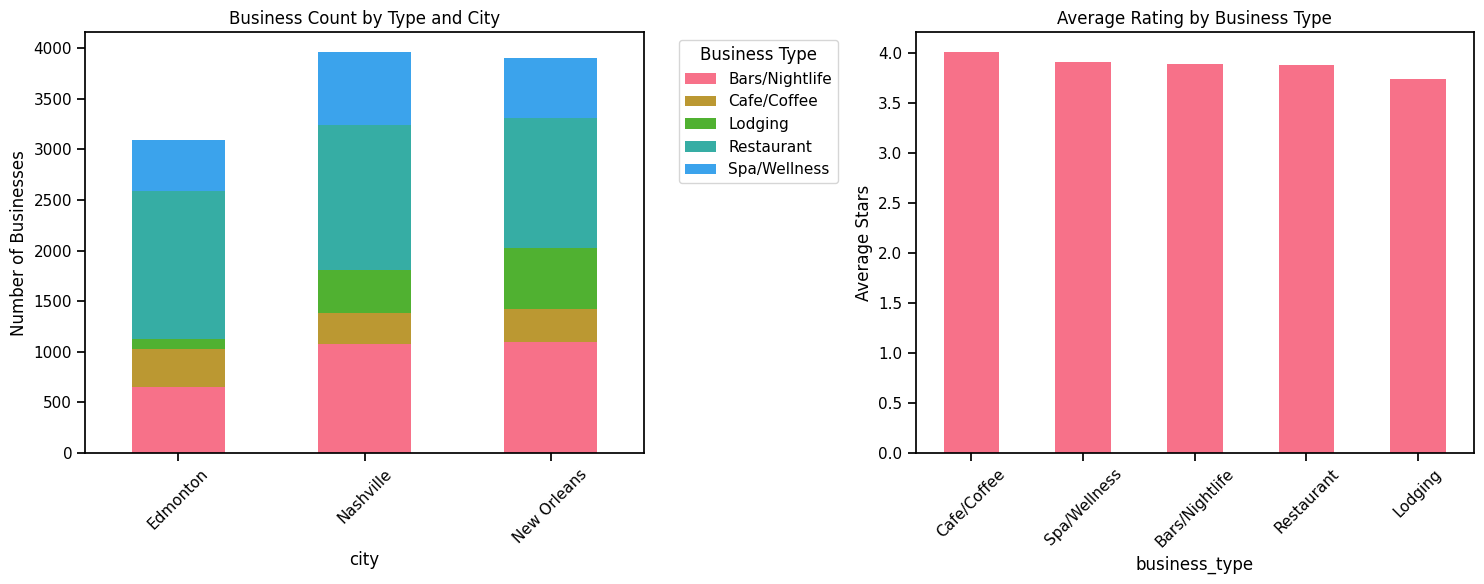

Business distribution by type:


business_type
Restaurant        4174
Bars/Nightlife    2819
Spa/Wellness      1814
Lodging           1128
Cafe/Coffee       1014
Name: count, dtype: int64


Average rating by business type:


,mean,count
business_type,,
Bars/Nightlife,3.89,370544
Cafe/Coffee,4.01,98750
Lodging,3.74,90281
Restaurant,3.88,414051
Spa/Wellness,3.91,71222


In [11]:
def categorize_business(categories):
    if not isinstance(categories, str):
        return 'Other'
    c = categories.lower()
    if any(w in c for w in ['hotel','motel','inn','resort','lodge']):
        return 'Lodging'
    if any(w in c for w in ['spa','massage','wellness','salon']):
        return 'Spa/Wellness'
    if any(w in c for w in ['bar','pub','brew','lounge','nightlife','wine bar']):
        return 'Bars/Nightlife'
    if any(w in c for w in ['cafe','coffee','bakery']):
        return 'Cafe/Coffee'
    if any(w in c for w in ['restaurant','food','diner','bistro']):
        return 'Restaurant'
    return 'Other'

sampled_biz['business_type'] = sampled_biz['categories'].apply(categorize_business)

reviews = reviews.merge(
    sampled_biz[['business_id','business_type']],
    on='business_id', how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
biz_type_city = sampled_biz.groupby(['city','business_type']).size().unstack(fill_value=0)
biz_type_city.plot(kind='bar', ax=axes[0], stacked=True)
axes[0].set_title('Business Count by Type and City')
axes[0].set_ylabel('Number of Businesses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Business Type', bbox_to_anchor=(1.05, 1), loc='upper left')

type_ratings = reviews.groupby('business_type')['stars'].mean().sort_values(ascending=False)
type_ratings.plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Rating by Business Type')
axes[1].set_ylabel('Average Stars')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Business distribution by type:")
display(sampled_biz['business_type'].value_counts())
print("\nAverage rating by business type:")
display(reviews.groupby('business_type')['stars'].agg(['mean','count']).round(2))

#### Conclusions from Business-Type Ratings & Counts

1. **Business Distribution by Type**
   - Restaurants (4174) and Bars/Nightlife (2819) dominate across cities, making them the core drivers of the dataset.
   - The consistency of business types across cities means we can infer a pattern of customer demand: food & nightlife > wellness > lodging.

2. **Average Ratings by Business Type**
   - Cafes/Coffee lead with the highest average rating (4.01).
   - Spa/Wellness (3.91), Bars/Nightlife (3.89), and Restaurants (3.88) follow closely, clustering near 3.9.
   - Lodging has the lowest rating (3.74), suggesting customers are more critical of hotels/motels which I infer is due to more and higher expectations on service, cleanliness, and amenities.

## Natural Language Processing (NLP)

### Text Prep

I create a lightweight, somewhat conservative text cleaner using NLTK (Natural Language Toolkit) that removes links, punctuation, and common filler words, while lowercasing everything so reviews are easier to analyze.

In [12]:
# NLTK setup
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', ' ', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', ' ', text) # Remove non-alphabetic characters       
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = [w for w in text.split() if w not in stop_words] # Remove stopwords
    return " ".join(words)

reviews['clean_text'] = reviews['text'].apply(clean_text)
display(reviews[['text','clean_text']].head(5))

,text,clean_text
0,Cute interior and owner (?) gave us tour of up...,cute interior owner gave us tour upcoming pati...
1,Loved this tour! I grabbed a groupon and the p...,loved tour grabbed groupon price great perfect...
2,"Service was crappy, and food was mediocre. I ...",service crappy food mediocre wish would picked...
3,I at least have to give this restaurant two st...,least give restaurant two stars due decent foo...
4,Amazing biscuits and (fill in the blank). Grea...,amazing biscuits fill blank great cocktails hi...


### Sentiment Analysis (VADER)

To avoid annoying memory errors on my end, I've computed VADER sentiment with 'swifter'. Of further note, I want sentiment only to distinguish phrases like “I may be biased, but I love…”, which are **positive** and should **not** count as unfair treatment

In [13]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)['compound']
    return np.nan

reviews['sentiment_score'] = reviews['text'].swifter.apply(sentiment_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adeal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Pandas Apply:   0%|          | 0/1044848 [00:00<?, ?it/s]

### Bias/Unfair Treatment Detection
 I attempt to seperate keyword presence from bias context:
 1. **`bias_flag`**: presence of any bias/unfair-treatment keyword (case-insensitive) in the cleaned text
 2.  **`bias_context`**: keyword present **and** sentiment is **negative** (compound < -0.2)

In [17]:
bias_keywords = [
    # Differential treatment
    "unfair", "treated differently", "different treatment", "singled out",
    "profiling", "stereotype", "biased", "discriminated", "discrimination",
    "racist", "racism", "sexist", "homophobic", "transphobic", "ableist",

    # Exclusion / access
    "refused service", "denied service", "not welcome", "unwelcome",
    "kicked out", "asked to leave", "no service",

    # Pricing inequality
    "overcharged", "charged extra", "different price", "price gouging", "double charged",

    # Interactions
    "rude", "dismissive", "ignored", "hostile", "condescending",
    "unfriendly", "disrespectful", "unprofessional", "offensive",

    # Queue
    "cut in line", "skipped line", "waited too long", "refused entry",
]

# Normalize to simple contains on cleaned text
kw_norm = [k.lower() for k in bias_keywords]

def has_bias_keyword(clean_text):
    if not isinstance(clean_text, str) or not clean_text:
        return False
    return any(k in clean_text for k in kw_norm)

reviews['bias_flag'] = reviews['clean_text'].apply(has_bias_keyword)

def in_bias_context(row):
    neg = (isinstance(row['sentiment_score'], (int, float)) and row['sentiment_score'] < -0.2)
    return bool(row['bias_flag'] and neg)

reviews['bias_context'] = reviews.apply(in_bias_context, axis=1)

bias_counts = (
    reviews.groupby('city')[['bias_flag','bias_context']]
    .mean().rename(columns={'bias_flag':'pct_bias_keyword', 'bias_context':'pct_bias_context'})
)
bias_counts['review_count'] = reviews.groupby('city').size()
display(bias_counts.sort_values('pct_bias_context', ascending=False).round(4))

,pct_bias_keyword,pct_bias_context,review_count
city,,,
Nashville,0.0369,0.0191,386223
Edmonton,0.0365,0.0178,78128
New Orleans,0.0357,0.0171,580497


### Neighborhood Analysis via Postal Codes

I treat each `postal_code` as a neighbourhood and calculated review counts, average ratings, and how often bias‑related complaints appear. I then compare sentiment scores between cities to show how the tone of reviews related to bias complaints is different from that of reviews in general within each city.

For mapping viz, see the Folium section below.

Postal-level stats (min reviews per postal code = 50):


,city,postal_code,reviews_count,pct_bias_context,avg_stars
756,Edmonton,T5V 1J2,65,0.107692,1.938462
491,Edmonton,T5L 4Y4,68,0.102941,2.602941
1245,Edmonton,T6N 1C2,111,0.099099,2.009009
96,Edmonton,T5G,67,0.089552,3.104478
738,Edmonton,T5T 5X1,99,0.080808,3.050505
132,Edmonton,T5G 3A6,237,0.080169,3.151899
60,Edmonton,T5C 3C8,80,0.075000,2.725000
1275,Edmonton,T6R 3L6,83,0.072289,3.096386
1083,Edmonton,T6G 2J7,56,0.071429,3.071429
148,Edmonton,T5H 0N7,58,0.068966,2.810345


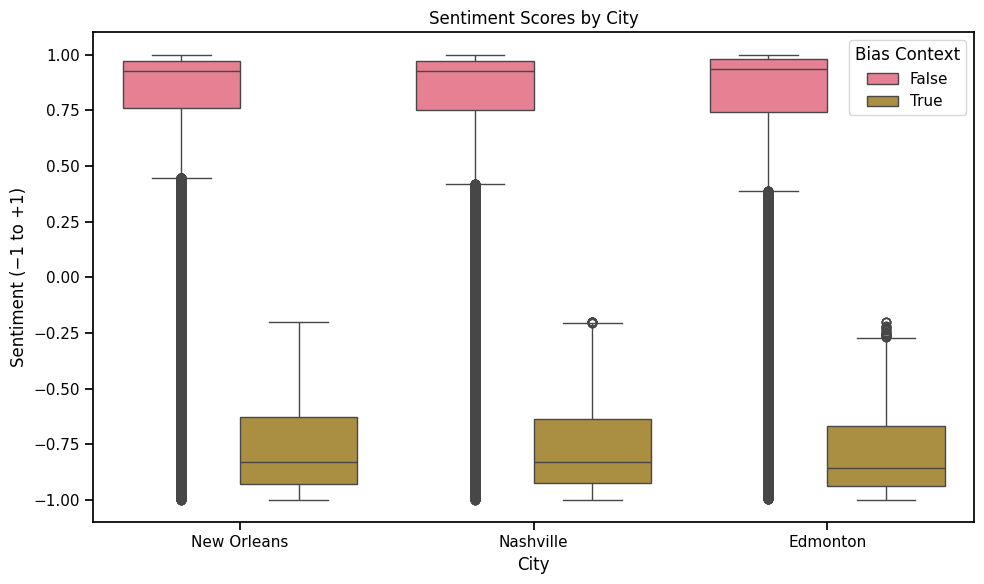

In [24]:
MIN_REVIEWS_PER_PC = 50

postal_stats = (
    reviews.groupby(['city','postal_code'])
    .agg(
        reviews_count=('review_id','count'),
        pct_bias_context=('bias_context','mean'),
        avg_stars=('stars','mean')
    )
    .reset_index()
)

postal_stats = postal_stats[postal_stats['reviews_count'] >= MIN_REVIEWS_PER_PC].copy()

print("Postal-level stats (min reviews per postal code = 50):")
display(postal_stats.sort_values(['city','pct_bias_context'], ascending=[True, False]).head(20))

# Sentiment by city and bias boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=reviews.dropna(subset=['sentiment_score']),
    x='city', y='sentiment_score', hue='bias_context'
)
plt.title('Sentiment Scores by City')
plt.ylabel('Sentiment (−1 to +1)')
plt.xlabel('City')
plt.legend(title='Bias Context')
plt.tight_layout()
plt.show()


#### Postal‑Level (Neighborhood Stats - Edmonton)
- In the Edmonton subset shown, bias complaints appear in ~6–11% of reviews in certain postal codes  
  (e.g., T5V 1J2: 10.8%, T6N 1C2: 9.9%).  
- These high‑bias postal codes have much lower average ratings (≈2.0 stars) compared to areas with fewer bias mentions (≈3.1–3.4 stars).  
- Evident pattern is more bias mentions > lower overall stars.

#### Boxplot (Sentiment by City & Bias Context)
- Non‑bias reviews: Median sentiment ≈ **~+0.9** (very positive) across New Orleans, Nashville, and Edmonton.  
- Bias reviews: Median sentiment ≈ **~−0.8**, with almost all reviews strongly negative.  
- The gap between bias vs. non‑bias sentiment is **~1.7 points wide** on a −1 to +1 scale.  
- This pattern is consistent across all three cities, showing that bias complaints are universally tied to more negative tone than general complaints. Edmonton however, does have a greater number of  outliers of bias reviews dipping into greater sentiment than expected. Needs more research outside the scope of this project.


### KMeans Neighborhood Clustering

I feel postal codes can be a bit coarse if we want to look at a geographical area for patterns. I've built nighborhood clusters per city using KMeans on business coords that should be easier for a non-technical to interact with.

**How it’s used here:**  
1. Fit KMeans with an adaptive number of clusters per city (chosen using silhouette scores)
2. Assign each business (and its reviews) to a cluster
3. Compute cluster-level metrics:  
   - Review count  
   - Average star rating  
   - % of reviews flagged with bias-context  
4. Visualize results on an interactive heatmap  
   - Heatmap shows areas where businesses and reviews concentrate  
   - High-bias clusters are labeled directly on the map with their bias rate and review volume

In [34]:
# Dynamic KMeans
def choose_dynamic_k(subset, min_k=5, max_k=30):
    n = len(subset)
    if n < 200: 
        return 3
    
    k_candidates = list(range(min_k, min(max_k, n // 200) + 1))
    
    best_k, best_score = min_k, -1
    for k in k_candidates:
        km = KMeans(n_clusters=k, n_init=5, random_state=42).fit(subset[['latitude','longitude']])
        labels = km.labels_
        if len(set(labels)) <= 1:
            continue
        try:
            score = silhouette_score(subset[['latitude','longitude']], labels)
            if score > best_score:
                best_k, best_score = k, score
        except:
            continue
    return best_k

def fit_dynamic_clusters(biz_df, cities, min_points=50):
    clusters = {}
    for c in cities:
        subset = biz_df[biz_df['city']==c].dropna(subset=['latitude','longitude']).copy()
        if len(subset) < min_points:
            print(f"Skipping {c}, not enough businesses.")
            continue
        
        k = choose_dynamic_k(subset)
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(subset[['latitude','longitude']])
        subset['cluster_id'] = km.labels_
        
        centers = pd.DataFrame(km.cluster_centers_, columns=['cluster_lat','cluster_lon'])
        centers['cluster_id'] = centers.index
        
        clusters[c] = {
            'assignments': subset[['business_id','cluster_id','latitude','longitude']],
            'centers': centers,
            'k': k
        }
        print(f"{c}: Dynamic KMeans w/ {k} clusters on {len(subset)} businesses")
    return clusters

clusters_by_city = fit_dynamic_clusters(sampled_biz, cities)

# Attach cluster_id to reviews

if 'city' not in reviews.columns:
    reviews = reviews.merge(sampled_biz[['business_id','city']], on='business_id', how='left')

reviews = reviews.copy()
reviews['cluster_id'] = np.nan

for c, bundle in clusters_by_city.items():
    assign = bundle['assignments'][['business_id','cluster_id']]
    reviews = reviews.merge(assign, on='business_id', how='left', suffixes=('', '_tmp'))
    reviews['cluster_id'] = reviews['cluster_id'].fillna(reviews['cluster_id_tmp'])
    reviews.drop(columns=['cluster_id_tmp'], inplace=True)

# Cluster summaries
cluster_summaries = {}
for c, bundle in clusters_by_city.items():
    sub = reviews[(reviews['city']==c) & (~reviews['cluster_id'].isna())].copy()
    if sub.empty: continue
    
    cs = sub.groupby('cluster_id').agg(
        reviews_count=('review_id','count'),
        pct_bias_context=('bias_context','mean'),
        avg_stars=('stars','mean')
    ).reset_index()
    
    cs = cs.merge(bundle['centers'], on='cluster_id', how='left')
    cluster_summaries[c] = cs

for c, df in cluster_summaries.items():
    print(f"\nCluster stats — {c} (k={clusters_by_city[c]['k']})")
    display(df.sort_values('pct_bias_context', ascending=False).head(10))

# Map viz
def show_heatmap_with_labels(city_name, assignments, summary, zoom_start=12,
                             low_thresh=0.01, high_thresh=0.03):
    if assignments is None or assignments.empty:
        print(f"No data for {city_name}")
        return None
    
    m = folium.Map(
        location=[assignments['latitude'].mean(), assignments['longitude'].mean()],
        zoom_start=zoom_start
    )
    
    # Heatmap of all business points
    heat_data = assignments[['latitude','longitude']].values.tolist()
    HeatMap(heat_data, radius=10, blur=15).add_to(m)
    
    # Add labels for biased clusters
    if summary is not None and not summary.empty:
        for _, row in summary.iterrows():
            bias = row['pct_bias_context']
            if bias > low_thresh:
                # Severity coloring
                if bias > high_thresh:
                    color = "red"
                else:
                    color = "orange"
                
                folium.Marker(
                    location=[row['cluster_lat'], row['cluster_lon']],
                    icon=folium.DivIcon(html=f"""
                        <div style="font-size:12px; color:{color}; font-weight:bold; 
                                    text-shadow:1px 1px 2px #fff;">
                            Bias {bias*100:.1f}% ({int(row['reviews_count'])} reviews)
                        </div>
                    """)
                ).add_to(m)
    
    return m

maps = {c: show_heatmap_with_labels(c, bundle['assignments'], cluster_summaries.get(c)) 
        for c, bundle in clusters_by_city.items()}

for c, m in maps.items():
    if m: display(m)


Edmonton: Dynamic KMeans → 7 clusters on 3089 businesses.
New Orleans: Dynamic KMeans → 7 clusters on 3900 businesses.
Nashville: Dynamic KMeans → 19 clusters on 3960 businesses.

Cluster stats — Edmonton (k=7)


,cluster_id,reviews_count,pct_bias_context,avg_stars,cluster_lat,cluster_lon
6,6.0,4832,0.029180,3.452815,53.598389,-113.531468
3,3.0,2382,0.024769,3.425273,53.472724,-113.421821
4,4.0,3849,0.024682,3.424786,53.586467,-113.426274
5,5.0,1937,0.021683,3.528653,53.445561,-113.587762
2,2.0,12397,0.021376,3.472453,53.464410,-113.492957
0,0.0,10197,0.020300,3.472394,53.532286,-113.616601
1,1.0,42534,0.013589,3.755231,53.536975,-113.504139



Cluster stats — New Orleans (k=7)


,cluster_id,reviews_count,pct_bias_context,avg_stars,cluster_lat,cluster_lon
6,6.0,2154,0.036676,3.572423,29.921735,-90.011444
1,1.0,3003,0.034299,3.615718,30.037678,-89.967847
4,4.0,4591,0.029623,3.695273,30.012407,-90.046186
5,5.0,48348,0.018408,3.931910,29.981565,-90.099249
2,2.0,409088,0.017155,3.936882,29.954968,-90.065537
3,3.0,26175,0.015244,3.961184,29.949601,-90.145610
0,0.0,87138,0.015022,4.029493,29.928448,-90.096373



Cluster stats — Nashville (k=19)


,cluster_id,reviews_count,pct_bias_context,avg_stars,cluster_lat,cluster_lon
17,17.0,2750,0.032364,3.529091,36.077718,-86.647771
18,18.0,4165,0.031453,3.521248,36.136562,-86.900211
3,3.0,17947,0.031092,3.402017,36.147408,-86.678240
15,15.0,2070,0.030435,3.571981,36.165162,-86.624151
0,0.0,13261,0.028580,3.603725,36.105738,-86.814774
10,10.0,6955,0.026743,3.834076,36.084490,-86.725634
13,13.0,113,0.026549,3.805310,35.931111,-86.855565
7,7.0,16427,0.025872,3.471480,36.214616,-86.701818
5,5.0,8372,0.025681,3.784520,36.036715,-86.719816
11,11.0,6510,0.023810,3.698157,36.121093,-86.860511


### Conclusion

#### New Orleans
There are clear differences in ratings and bias values across neighbourhoods in New Orleans, especially in the 70130, 70116, and 70118 postal codes.  For example, 70130, which includes parts of the French Quarter, Central Business District, and Warehouse District, has ratings that range from very low (≈2.6) to very high (≈5.0).  This suggests that businesses in the same general area can give customers very different experiences. The elevated bias values in some places suggest reviews can be shaped by toursits unfamiliar with local norms who may judge service, pricing, or staff behvaiour more harshly.

In 70116 (French Quarter, Marigny, Treme), a lot of reviews tend to keep the average rating close to 3.9–4.0, which makes the impact of a few very bad or very good reviews less strong. 70118 (Audubon, Uptown) also has mostly good ratings, but there are some areas where the ratings are lower.

Overall, we can see the bias effects are most noticeable in smaller postal code areas with fewer reviews between neighborhoods. High-volume neighborhoods like the French Quarter show relatively balanced ratings, whereas outside areas with fewer establishments can exaggerate swings.

#### Edmonton

Most neighbourhoods in Edmonton have average ratings between 3.5 and 4.5 stars, which makes the city's postal codes more consistent.  For example, T6E (Old Strathcona, Ritchie, Bonnie Doon) and T6G (University of Alberta area) ratings stay close to the city average.

In contrast, T5P (West Edmonton, near Jasper Place and Meadowlark) sometimes has lower averages (about 1.6–2.5 in some businesses) with a clear bias toward certain areas. T5P 3Z6 only had 11 reviews but a bias of 0.18, which, for me, shows how small sample sizes can make things seem worse than they are. Plus, thinking in terms of social determinants, outer working-class neighborhoods can experience negative bias linked to social stigma or economic disadvantage.

#### Nashville

Nashville has the most differences between neighbourhoods of the three cities.  Certain areas, like 37221 (Bellevue, southwest Nashville) and 37208 (North Nashville, near Germantown and Buena Vista), have high bias values (≈0.23–0.29), which means that they have a big effect on how people see things in those areas. From my (very) quick research, Germantown’s rapid gentrification and trendiness may actually have spurred inflated ratings (Google "Gemantown gentification" for many articles on this subject)

The most reviews come from central neighbourhoods like 37203 (Midtown, Music Row, The Gulch) and 37201 (Downtown, SoBro area).  Their averages (about 3.6 to 4.2) are pretty stable, which shows that having more reviewers can make outliers less important (i.e. wisdom of the crowd effect).

Postal codes like 37214 (Donelson, near the airport) and 37209 (The Nations, Charlotte Park, Sylvan Park) often have lower averages. I feel like this suggests that the people who live in these neighbourhoods feel differently about the city as a whole. Further research is needed.

In general, I think that the neighbourhood context has a big effect on Nashville's ratings.

---
One important observation I have from this project is that all three cities showed a consistent inverse relationship between the number of reviews and the volatility and bias of the ratings. Locations with a lot of traffic tend to have stable, moderate average ratings with little bias. Places with little traffic, on the other hand, tend to have extreme bias and significant fluctuations. The French Quarter in New Orleans (70116) and downtown Nashville (37203, 37201) are good examples of places that get a lot of tourists and have a lot of businesses, which leads to hundreds or even thousands of reviews. This makes extreme opinions less powerful and normalizes overall sentiment. On the other hand, smaller or newer neighbourhoods, like T5P 3Z6 in Edmonton and 37209 in Nashville, usually have fewer reviews. Consequently, their average ratings and bias values can be easily changed by a few strong opinions. This shows that low-volume areas may seem "biased," but this bias is usually just a statistical artifact and not a problem that affects the whole system.

For more technical readers: In fact, I feel this can boil down into a discussion on the law of large numbers: as the number of independent observations (reviews) increases, the sample mean (average rating) converges towards the true population mean (actual underlying sentiment), and the influence of individual outliers decreases.